In [1]:
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# optimized force vectors obtained by using provide solution
optimized_force_vectors = np.load('target_foce_vectors.npy')
optimized_force_vectors.shape

(100, 20)

In [3]:
starting_points = torch.zeros((100,2))
starting_points[:,0] = -1
r1 = -.01
r2 = .01
starting_points[:,1] = torch.rand(100) * (r2 - r1) - r2
starting_points.shape

torch.Size([100, 2])

In [4]:
y0 = starting_points[:, 1]
y0 = y0.reshape(100, 1)
y0.shape

torch.Size([100, 1])

In [5]:
network = nn.Sequential(
    nn.Linear(1, 10),
    nn.ReLU(),
    nn.Linear(10, 20)
)
network

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=20, bias=True)
)

In [6]:
optimizer = torch.optim.Adam(network.parameters(), 10)
loss_function = nn.MSELoss()

In [7]:
targets = torch.from_numpy(optimized_force_vectors)
targets.shape

torch.Size([100, 20])

In [8]:
dataset = TensorDataset(y0, targets)
#single batch training
dataloader = DataLoader(dataset, batch_size=100, shuffle=True)

In [10]:
for i in range(1500):
    for input, target in dataloader:
        optimizer.zero_grad()
        prediction = network(input) # input of nn is y0
        loss = loss_function(prediction, target)
        loss.backward()
        optimizer.step()
    if(i + 1) % 100 == 0:
         print(f"Iteration {i + 1}, Loss: {loss.item():.4f}")

Iteration 100, Loss: 0.0411
Iteration 200, Loss: 0.0144
Iteration 300, Loss: 0.0144
Iteration 400, Loss: 0.0144
Iteration 500, Loss: 0.0144
Iteration 600, Loss: 0.0144
Iteration 700, Loss: 0.0144
Iteration 800, Loss: 0.0144
Iteration 900, Loss: 0.0144
Iteration 1000, Loss: 0.0144
Iteration 1100, Loss: 0.0144
Iteration 1200, Loss: 0.0144
Iteration 1300, Loss: 0.0144
Iteration 1400, Loss: 0.0144
Iteration 1500, Loss: 0.0144


In [31]:
test_points = torch.zeros((25,1))
r1 = -.01
r2 = .01
test_points = torch.rand(25) * (r2 - r1) - r2

In [32]:
x_traj = [-1] # same traj for all points
for i in range(20):
    x_traj.append(x_traj[-1] + .1)

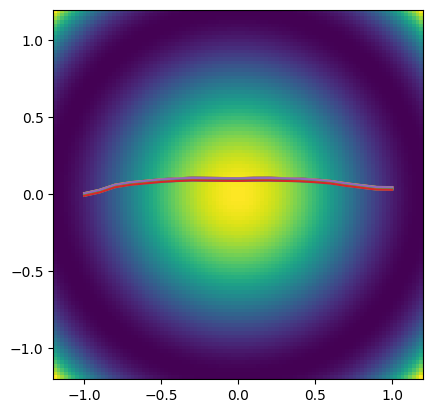

In [33]:
x,y = np.meshgrid(np.linspace(-1, 1, 100), np.linspace(-1, 1, 100))
z = (x ** 2 + y ** 2  - 1) ** 2
plt.imshow(z, extent = [-1.2, 1.2, -1.2, 1.2])

for i in range(25):
    with torch.no_grad():
        force_vec = network(test_points[i].unsqueeze(0))
    y_traj = [test_points[i]]
    for i in range(20):
        y_traj.append(y_traj[-1] + force_vec[i])
    plt.plot(x_traj, y_traj)
